# Laboratorio III
## Unificación de datasets y Análisis Exploratorio

En este notebook se integrarán las diferentes fuentes de datos y se realizará un primer análisis exploratorio para entender la distribución de ventas (tn) y preparar el forecasting.

---

### 1. Importar librerías

Se importan las librerías necesarias para manipulación de datos y visualización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

### 2. Carga de datos

- **`products`**: datos de catálogo de productos.
- **`stocks`**: stock final por producto y periodo.
- **`main`**: dataset principal de ventas por cliente/producto/periodo.

## 2.1 Descripción de columnas

Dataset **sell-in**

| Columna                  | Descripción                                                                                                                                                                                                 |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **periodo**              | Periodo en formato `AAAAMM` correspondiente al mes de la foto de ventas. Por ejemplo, `202504` incluye todas las ventas entre `2025-04-01 00:00:00` y `2025-04-30 23:59:59`.                               |
| **customer_id**          | Identificador único de cliente (~550 clientes: cadenas de supermercados, mayoristas, distribuidores). Puede haber clientes pequeños que no registren compras en un mes determinado.                            |
| **product_id**           | Identificador único del producto.                                                                                                                                                                             |
| **plan_precios_cuidados**| Indicador binario (`0` o `1`) de participación en el Plan Precios Cuidados impulsado por el gobierno.                                                                                                         |
| **cust_request_qty**     | Cantidad de cajas solicitadas por el cliente en el mes, neta de órdenes caídas. La unidad mínima de pedido es 1 caja, que puede contener distinto número de envases según el producto.                         |
| **cust_request_tn**      | Toneladas solicitadas, calculadas como `cust_request_qty` × peso en toneladas de una caja de ese producto.                                                                                                   |
| **tn**                   | Toneladas reales vendidas del producto a ese cliente en el periodo (campo principal para análisis).   


Dataset **tb_productos**

| Columna                  | Descripción                                                                                                                                                                                                 |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **cat1**              | Categoría principal del producto, Home care, Personal care o Food.                               |
| **cat2**          | Categoría de producto dentro de la categoría principal                            |
| **cat3**           | Subcategoría dentro de la categoría del producto.                                                                                                                                                           |
| **brand**         | Marca del producto.                                                                                                         |
| **sku_size**     |                      |
| **product_id**      | Identificador único del producto.                                                                                                    |


Dataset **tb_stocks**

| Columna                  | Descripción                                                                                                                                                                                                 |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **periodo**              | Periodo en formato `AAAAMM` correspondiente al mes de la foto de ventas. Por ejemplo, `202504` incluye todas las ventas entre `2025-04-01 00:00:00` y `2025-04-30 23:59:59`.                               |
| **product_id**          | Identificador único del producto.                            |
| **stock_final**           | La informacion de stocks indica cuanto stock de ese product_id quedaba a las 23:59:59 del ultimo dia del mes.                                                                                                                                                           |                                                                                                |


In [2]:
# Leer catálogo de productos
tb_productos = pd.read_csv('datasets/tb_productos.txt', sep='\t')
print(f"El dataset 'tb_productos' tiene {tb_productos.shape[0]} filas y {tb_productos.shape[1]} columnas")

# Leer stock final
tb_stocks = pd.read_csv('datasets/tb_stocks.txt', sep='\t')
print(f"El dataset 'tb_stocks' tiene {tb_stocks.shape[0]} filas y {tb_stocks.shape[1]} columnas")


# Leer dataset principal en chunks si es muy grande
chunks = pd.read_csv('datasets/sell-in.txt', sep='\t', chunksize=1_000_000)
sell_in = pd.concat(chunks)
print(f"El dataset 'sell_in' tiene {sell_in.shape[0]} filas y {sell_in.shape[1]} columnas")

El dataset 'tb_productos' tiene 1262 filas y 6 columnas
El dataset 'tb_stocks' tiene 13691 filas y 3 columnas
El dataset 'sell_in' tiene 2945818 filas y 7 columnas


### 3. Inspección inicial

Verificar estructura y valores faltantes.

In [3]:
sell_in.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [4]:
tb_productos.head()

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [5]:
sell_in.info()
sell_in.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB


periodo                  0
customer_id              0
product_id               0
plan_precios_cuidados    0
cust_request_qty         0
cust_request_tn          0
tn                       0
dtype: int64

In [6]:
num_dup_rows = sell_in.duplicated().sum()
print(f"Filas duplicadas en sell_in: {num_dup_rows}")

Filas duplicadas en sell_in: 0


In [7]:
tb_productos.head()

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [8]:
tb_productos.info()
tb_productos.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cat1        1262 non-null   object
 1   cat2        1262 non-null   object
 2   cat3        1262 non-null   object
 3   brand       1262 non-null   object
 4   sku_size    1262 non-null   int64 
 5   product_id  1262 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 59.3+ KB


cat1          0
cat2          0
cat3          0
brand         0
sku_size      0
product_id    0
dtype: int64

In [9]:
num_dup_rows = tb_productos.duplicated().sum()
print(f"Filas duplicadas en tb_productos: {num_dup_rows}")

Filas duplicadas en tb_productos: 9


In [10]:
# Eliminar duplicados 
tb_productos.drop_duplicates(inplace=True)

In [11]:
num_dup_rows = tb_productos.duplicated().sum()
print(f"Filas duplicadas en tb_productos: {num_dup_rows}")

Filas duplicadas en tb_productos: 0


In [12]:
# Agrupar por product_id y contar registros, ordenando de forma descendente
conteo_productos = tb_productos.groupby('product_id').size().sort_values(ascending=False)
print("Cantidad de registros por product_id en tb_productos (orden descendente):")
display(conteo_productos.head(10))  # muestra los 10 con más repeticiones

Cantidad de registros por product_id en tb_productos (orden descendente):


product_id
20623    2
20230    2
20001    1
20836    1
20843    1
20842    1
20841    1
20840    1
20839    1
20838    1
dtype: int64

In [13]:
tb_productos[tb_productos['product_id'].isin(values=[20623, 20230])]

,cat1,cat2,cat3,brand,sku_size,product_id
915,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,350,20623
917,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,350,20230
981,PC,CABELLO,SHAMPOO,SHAMPOO3,350,20623
983,PC,CABELLO,SHAMPOO,SHAMPOO3,350,20230


Los productos con PRODUCT_ID 20623 y 20230 figuran tanto como SHAMPOO como ACONDICIONADOR por lo que en ese caso hay que tomar alguna decisión cual se elimina y cual se conserva para no duplicar datos de las ventas al reunir los datos.

In [14]:
tb_productos_clean = (
    tb_productos.groupby('product_id')
    .agg({
        'cat1': 'first',
        'cat2': 'first',
        'cat3': lambda x: ','.join(sorted(set(x))),
        'brand': 'first',
        'sku_size': 'first'
    })
    .reset_index()
)
tb_productos_clean[tb_productos_clean['product_id'].isin(values=[20623, 20230])]

,product_id,cat1,cat2,cat3,brand,sku_size
229,20230,PC,CABELLO,"ACONDICIONADOR,SHAMPOO",SHAMPOO3,350
620,20623,PC,CABELLO,"ACONDICIONADOR,SHAMPOO",SHAMPOO3,350


In [15]:
tb_stocks.head()

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


In [16]:
tb_stocks.info()
tb_stocks.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13691 entries, 0 to 13690
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   periodo      13691 non-null  int64  
 1   product_id   13691 non-null  int64  
 2   stock_final  13691 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 321.0 KB


periodo        0
product_id     0
stock_final    0
dtype: int64

In [17]:
num_dup_rows = tb_stocks.duplicated().sum()
print(f"Filas duplicadas en tb_stocks: {num_dup_rows}")

Filas duplicadas en tb_stocks: 0


### 4. Unificación de tablas

Se unen las tablas con **`product_id`** y **`periodo`**.

In [18]:
# Merge con catálogo de productos
df = sell_in.merge(tb_productos, on='product_id', how='left')
assert df.shape[0] == sell_in.shape[0], f"Merge con productos duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

# # Merge con stock final
# df = sell_in.merge(tb_stocks, on=['periodo', 'product_id'], how='left')
# assert df.shape[0] == sell_in.shape[0], f"Merge con stocks duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

# print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

AssertionError: Merge con productos duplicó filas: 2951443 vs 2945818

Detectamos duplicados en tb_productos, 1 product id tiene asociado dos cat3 distintas haciendo que genere duplicados. Hicimos una limpieza y conservamos ambas cat3 separado por ",", ahora utilizaremos **tb_productos_clean** para joinear.

In [19]:
# Merge con catálogo de productos
df = sell_in.merge(tb_productos_clean, on='product_id', how='left')
assert df.shape[0] == sell_in.shape[0], f"Merge con productos duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

# Merge con stock final
df = df.merge(tb_stocks, on=['periodo', 'product_id'], how='left')
assert df.shape[0] == sell_in.shape[0], f"Merge con stocks duplicó filas: {df.shape[0]} vs {sell_in.shape[0]}"

print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

El dataset tiene 2945818 filas y 13 columnas


In [20]:
df['periodo'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m').dt.strftime('%Y-%m')

In [21]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
0,2017-01,10234,20524,0,2,0.05300,0.05300,HC,VAJILLA,Cristalino,Importado,500.0,NaN
1,2017-01,10032,20524,0,1,0.13628,0.13628,HC,VAJILLA,Cristalino,Importado,500.0,NaN
2,2017-01,10217,20524,0,1,0.03028,0.03028,HC,VAJILLA,Cristalino,Importado,500.0,NaN
3,2017-01,10125,20524,0,1,0.02271,0.02271,HC,VAJILLA,Cristalino,Importado,500.0,NaN
4,2017-01,10012,20524,0,11,1.54452,1.54452,HC,VAJILLA,Cristalino,Importado,500.0,NaN


### Filtramos los id que debemos predecir

In [22]:
productos_keep = pd.read_csv("product_id_apredecir201912.csv")
productos_keep.shape

(780, 1)

In [23]:
productos_keep.head()

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


In [24]:
# Filtrar el DataFrame para mantener solo los productos en productos_keep
df_filtrado = df[df['product_id'].isin(productos_keep['product_id'])]

# 3. Verifica
print(f"Filas totales antes de filtrar: {len(df)}")
print(f"Filas totales tras filtrar: {len(df_filtrado)}")
print("Product id unicos: ", df_filtrado['product_id'].nunique())

Filas totales antes de filtrar: 2945818
Filas totales tras filtrar: 2293481
Product id unicos:  780


In [25]:
df_filtrado.to_csv('sell_in_filtrado.csv', index=False, sep='\t')

### Análisis de brechas (gaps) entre compras de un mismo cliente-producto 

Para cada pareja <product_id, customer_id>, identificar todos los meses en que sí hubo venta, ordenados cronológicamente. Luego calcular los intervalos (en meses) entre cada venta y la siguiente venta de esa misma pareja. Eso nos da la distribución de “tiempo sin comprar antes de volver a comprar”.

In [26]:
import pandas as pd
df_filtrado = pd.read_csv('sell_in_filtrado.csv', sep='\t')

In [27]:
# Partimos de df_ventas con ['periodo','customer_id','product_id','tn'] 
# y ya convertido a PeriodIndex:
df = df_filtrado.copy()
df['period'] = pd.to_datetime(df['periodo'], format='%Y-%m').dt.to_period('M')

# 1) Quedarnos solo con filas donde tn > 0 (meses con venta)
df_activos = df[df['tn'] > 0].copy()

# 2) Para cada pareja, ordenamos por fecha y calculamos la diferencia (en meses),
#    cuidando de no llamar a .n si el valor es NaT:
def diff_months(series_periods):
    diffs = series_periods.diff()
    return diffs.apply(lambda d: d.n if pd.notna(d) else pd.NA)

df_gaps = (
    df_activos
    .sort_values(['product_id','customer_id','period'])
    .groupby(['product_id','customer_id'])['period']
    .apply(diff_months)
    .reset_index(name='gap_months')
)

# El primer registro de cada grupo tendrá gap_months = <NA>.
# Repasamos estadísticas:
gap_stats = df_gaps['gap_months'].describe().round(1)
print(gap_stats)

percentiles = df_gaps['gap_months'].quantile([0.75, 0.9, 0.95, 0.99]).round(1)
print(percentiles)

count     2030676
unique         35
top             1
freq      1071080
Name: gap_months, dtype: int64
0.75     3.0
0.90     5.0
0.95     7.0
0.99    13.0
Name: gap_months, dtype: object


El valor del percentil 95 % = 7 meses significa que solo el 5 % de las veces una pareja estuvo más de 7 meses sin comprar antes de volver a hacerlo.
El valor del percentil 99 % = 13 meses significa que solo el 1 % de las veces una pareja estuvo más de 13 meses sin comprar antes de volver a hacerlo.

Si consideras que 13 meses sin compra ya es “matar” la relación (es muy raro que luego vuelvan), podrías poner el corte en 13.


**Podrías incluso “diferenciar por categoría” y ver si en cat3 = “Sopas” el gap tiende a ser más corto (por estacionalidad) que en cat3 = “Desodorantes”, etc.**

### Análisis de supervivencia («time‐to‐event») para clientes y productos

Con este analisis se busca, no solo la longitud bruta de cada gap, sino entender la probabilidad de “recuperación” a medida que el tiempo pasa. Esto es un análisis de supervivencia: para cada mes t tras la última compra, ¿cuál es la probabilidad de que vuelvan a comprar en el futuro?


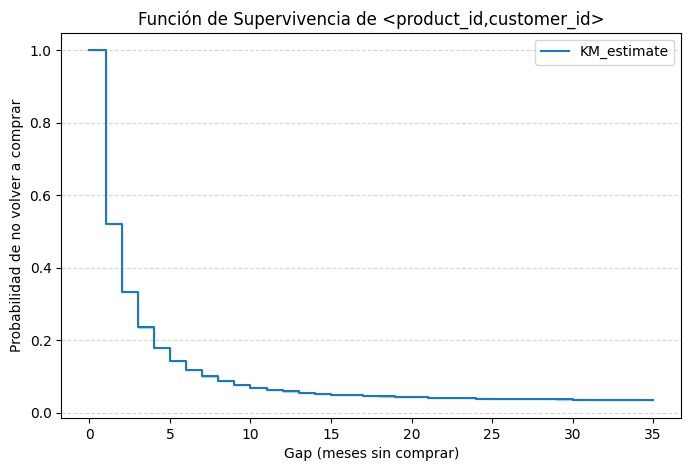

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter


# — Asumimos que df_filtrado ya existe con columnas ['periodo','customer_id','product_id','tn'] —
# y que 'periodo' está en formato 'YYYY-MM' (o 'YYYYMM').

# PASO A: Convertir 'periodo' a PeriodIndex mensual
df = df_filtrado.copy()
df['period'] = pd.to_datetime(df['periodo'], format='%Y-%m').dt.to_period('M')

# PASO B: Filtrar solo meses con venta (tn > 0)
df_activos = df[df['tn'] > 0].copy()

# PASO C: Calcular, para cada pareja <product_id, customer_id>, los gaps en meses
def diff_months(series_periods):
    diffs = series_periods.diff()  # diferencia entre períodos consecutivos
    # Convertir cada intervalo a número de meses; si es NaT, dejar NA
    return diffs.apply(lambda d: d.n if pd.notna(d) else pd.NA)

df_activos = (
    df_activos
    .sort_values(['product_id','customer_id','period'])
    .groupby(['product_id','customer_id'])['period']
    .apply(diff_months)
    .reset_index(name='gap_months')
)

# Ahora df_activos tiene estas columnas: ['product_id','customer_id','period','gap_months']

# PASO D: Calcular última venta de cada pareja (para censura)
ultima_venta = (
    df[df['tn'] > 0]
    .groupby(['product_id','customer_id'])['period']
    .max()
    .reset_index(name='last_sale')
)

# Definir horizonte final (por ejemplo, 2019-12)
ultimo_periodo = df['period'].max()  # debería ser 2019-12
# Calcular cuántos meses pasan desde la última venta hasta el horizonte
ultima_venta['censor_gap'] = (ultimo_periodo - ultima_venta['last_sale']).apply(lambda d: d.n)

# PASO E: Construir el listado de gaps reales (event_observed = 1)
gaps_list = []
# Iterar solo sobre las filas donde gap_months no es NA (gap real)
for _, row in df_activos.dropna(subset=['gap_months']).iterrows():
    gaps_list.append({
        'gap_months': int(row['gap_months']),  # convertir a int
        'event_observed': 1
    })

# PASO F: Agregar para cada pareja su gap censurado (event_observed = 0)
for _, row in ultima_venta.iterrows():
    gaps_list.append({
        'gap_months': int(row['censor_gap']),
        'event_observed': 0
    })

# Crear DataFrame de supervivencia
df_surv = pd.DataFrame(gaps_list)

# PASO G: Ajustar Kaplan–Meier
kmf = KaplanMeierFitter()
kmf.fit(durations=df_surv['gap_months'], event_observed=df_surv['event_observed'])

# Mostrar la curva de supervivencia
plt.figure(figsize=(8,5))
kmf.plot_survival_function()
plt.title('Función de Supervivencia de <product_id,customer_id>')
plt.xlabel('Gap (meses sin comprar)')
plt.ylabel('Probabilidad de no volver a comprar')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


A partir de ese gráfico se ve que, por ejemplo, que S(3) = 0.40 y S(15) = 0.05. Si consideras “morir” la relación cuando hay menos del 5 % de probabilidad de retomar, entonces el corte estaría en 15 meses aprox.

In [29]:
df_filtrado.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
0,2017-01,10234,20524,0,2,0.05300,0.05300,HC,VAJILLA,Cristalino,Importado,500.0,NaN
1,2017-01,10032,20524,0,1,0.13628,0.13628,HC,VAJILLA,Cristalino,Importado,500.0,NaN
2,2017-01,10217,20524,0,1,0.03028,0.03028,HC,VAJILLA,Cristalino,Importado,500.0,NaN
3,2017-01,10125,20524,0,1,0.02271,0.02271,HC,VAJILLA,Cristalino,Importado,500.0,NaN
4,2017-01,10012,20524,0,11,1.54452,1.54452,HC,VAJILLA,Cristalino,Importado,500.0,NaN


## Rellenar periodos con 0

In [27]:
df_filtrado['fecha'] = df_filtrado['periodo'].astype('period[M]')

In [34]:
def completar_series_temporales(df,umbral_meses=15):
    """
    Completa las series temporales de productos y clientes cuando AMBOS estaban activos.
    Un cliente o producto se considera 'MUERTO' si entre la ultima fecha del dataset y su ultima fecha de compra pasaron mas de X meses definido por un umbral.
    Para el resto, se considera activo desde su primera compra hasta el fin del dataset.
    """
    import pandas as pd

    df['fecha'] = df['fecha'].astype('period[M]')

    columnas_a_rellenar = ['cust_request_qty', 'cust_request_tn', 'tn']

    # Última fecha del dataset
    fecha_max_dataset = df['fecha'].max()

    # Definir umbral de inactividad
    umbral_fecha = fecha_max_dataset - umbral_meses

    # Fechas de inicio y fin por cliente y producto
    fechas_clientes = df.groupby('customer_id')['fecha'].agg(fecha_ini_c='min', fecha_fin_c='max').reset_index()
    fechas_productos = df.groupby('product_id')['fecha'].agg(fecha_ini_p='min', fecha_fin_p='max').reset_index()

    # Determinar cuáles clientes y productos están inactivos
    fechas_clientes['inactivo'] = fechas_clientes['fecha_fin_c'] <= umbral_fecha
    fechas_productos['inactivo'] = fechas_productos['fecha_fin_p'] <= umbral_fecha

    # Si está inactivo, se respeta la última fecha real; si no, se extiende hasta el final del dataset
    fechas_clientes['fecha_fin_c'] = fechas_clientes.apply(
        lambda x: x['fecha_fin_c'] if x['inactivo'] else fecha_max_dataset, axis=1
    )
    fechas_productos['fecha_fin_p'] = fechas_productos.apply(
        lambda x: x['fecha_fin_p'] if x['inactivo'] else fecha_max_dataset, axis=1
    )

    # Crear rango completo de fechas en formato Period[M]
    fechas = pd.period_range(df['fecha'].min(), fecha_max_dataset, freq='M')
    fechas_df = pd.DataFrame({'fecha': fechas})

    # Crear combinaciones válidas cliente-fecha
    clientes_fechas = fechas_clientes.merge(fechas_df, how='cross')
    clientes_fechas = clientes_fechas[
        (clientes_fechas['fecha'] >= clientes_fechas['fecha_ini_c']) &
        (clientes_fechas['fecha'] <= clientes_fechas['fecha_fin_c'])
    ][['customer_id', 'fecha']]

    # Crear combinaciones válidas producto-fecha
    productos_fechas = fechas_productos.merge(fechas_df, how='cross')
    productos_fechas = productos_fechas[
        (productos_fechas['fecha'] >= productos_fechas['fecha_ini_p']) &
        (productos_fechas['fecha'] <= productos_fechas['fecha_fin_p'])
    ][['product_id', 'fecha']]

    # Crear combinaciones cliente-producto-fecha donde ambos estaban activos
    combinaciones_validas = productos_fechas.merge(clientes_fechas, on='fecha', how='inner')

    # Merge con el dataset original
    df_completo = combinaciones_validas.merge(df, on=['product_id', 'customer_id', 'fecha'], how='left')

    # Completar valores faltantes con 0 en las columnas de cantidad
    df_completo[columnas_a_rellenar] = df_completo[columnas_a_rellenar].fillna(0)

    # Ordenar por producto, cliente y fecha
    df_completo = df_completo.sort_values(['product_id', 'customer_id', 'fecha'])

    return df_completo.reset_index(drop=True)

In [35]:
df_filtrado.shape

(2299106, 14)

In [36]:
completar_series_temporales(df_filtrado)

,product_id,fecha,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
0,20001,2017-01,10001,2017-01,0.0,11.0,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
1,20001,2017-02,10001,2017-02,0.0,23.0,198.84365,198.84365,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
2,20001,2017-03,10001,2017-03,0.0,33.0,92.46537,92.46537,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
3,20001,2017-04,10001,2017-04,0.0,8.0,13.29728,13.29728,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
4,20001,2017-05,10001,2017-05,0.0,15.0,101.20711,101.00563,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11349852,21276,2019-10,10609,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
11349853,21276,2019-11,10609,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
11349854,21276,2019-12,10609,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
11349855,21276,2019-11,10618,NaN,NaN,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN


### Rellenar los periodos customer id y product id donde se decidio no comprar pero los productos y customers ya habian nacido

In [28]:
df_filtrado.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
0,2017-01,10234,20524,0,2,0.05300,0.05300,HC,VAJILLA,Cristalino,Importado,500.0,NaN
1,2017-01,10032,20524,0,1,0.13628,0.13628,HC,VAJILLA,Cristalino,Importado,500.0,NaN
2,2017-01,10217,20524,0,1,0.03028,0.03028,HC,VAJILLA,Cristalino,Importado,500.0,NaN
3,2017-01,10125,20524,0,1,0.02271,0.02271,HC,VAJILLA,Cristalino,Importado,500.0,NaN
4,2017-01,10012,20524,0,11,1.54452,1.54452,HC,VAJILLA,Cristalino,Importado,500.0,NaN


In [30]:
import pandas as pd

# Supongamos que df ya tiene las columnas correctas y 'periodo' como string (tipo '2017-01')
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y-%m').dt.to_period('M')
ultimo_periodo = pd.Period('2019-12', freq='M')

dfs_expand = []

for (product_id, customer_id), group in df.groupby(['product_id', 'customer_id']):
    primer_periodo = group['periodo'].min()
    periodos = pd.period_range(start=primer_periodo, end=ultimo_periodo, freq='M')
    
    # Tomamos los valores fijos del primer registro del grupo
    cat1 = group['cat1'].iloc[0]
    cat2 = group['cat2'].iloc[0]
    cat3 = group['cat3'].iloc[0]
    brand = group['brand'].iloc[0]
    
    full_idx = pd.DataFrame({
        'periodo': periodos,
        'product_id': product_id,
        'customer_id': customer_id,
        'cat1': cat1,
        'cat2': cat2,
        'cat3': cat3,
        'brand': brand
    })
    full_idx = full_idx.set_index('periodo')
    group = group.set_index('periodo')
    expanded = full_idx.join(group[['tn']], how='left')  # Solo traigo 'tn' porque el resto ya lo tengo
    
    expanded['tn'] = expanded['tn'].fillna(0)
    expanded = expanded.reset_index()
    dfs_expand.append(expanded)

df_final = pd.concat(dfs_expand, ignore_index=True)

In [31]:
df_final.shape

(6910872, 8)

In [46]:
df = df_filtrado.copy()
df['period'] = pd.to_datetime(df['periodo'], format='%Y-%m').dt.to_period('M')

In [47]:
# 1) Calcular el primer periodo (nacimiento) de cada producto y cada cliente
prod_nac = (
    df
    .groupby('product_id')['period']
    .min()
    .reset_index()
    .rename(columns={'period': 'prod_start'})
)

cust_nac = (
    df
    .groupby('customer_id')['period']
    .min()
    .reset_index()
    .rename(columns={'period': 'cust_start'})
)

In [48]:
# 2) Extraer SOLO las parejas que al menos una vez compraron juntas
parejas_ventas = (
    df[['product_id','customer_id']]
    .drop_duplicates()
    # Unimos el nacimiento de producto y cliente
    .merge(prod_nac, on='product_id', how='left')
    .merge(cust_nac, on='customer_id', how='left')
)

print(f"Parejas que al menos una vez compraron juntas: {parejas_ventas.shape[0]}")

Parejas que al menos una vez compraron juntas: 262805


In [49]:
# 3) Para cada pareja, “nacimiento conjunto” = max(prod_start, cust_start)
parejas_ventas['start'] = parejas_ventas[['prod_start','cust_start']].max(axis=1)

In [50]:
# 4) Definir horizonte final y listar meses desde cada start hasta el último mes disponible
ultimo_periodo = df['period'].max()  
print("Último periodo:", ultimo_periodo)

rows = []
for _, fila in parejas_ventas.iterrows():
    pid = fila['product_id']
    cid = fila['customer_id']
    mes_inicio = fila['start']
    
    if pd.isna(mes_inicio):
        continue
    
    # Generar todos los meses desde mes_inicio hasta ultimo_periodo
    meses_vivos = pd.period_range(mes_inicio, ultimo_periodo, freq='M')
    for mes in meses_vivos:
        rows.append((mes, pid, cid))

df_full = pd.DataFrame(rows, columns=['period','product_id','customer_id'])
df_full.shape

Último periodo: 2019-12


(7781619, 3)

In [51]:
# 5) Unir con ventas reales y rellenar ceros solo para esos pares
df_full = df_full.merge(
    df[['period','product_id','customer_id','tn','cat1']],
    on=['period','product_id','customer_id'],
    how='left'
)
df_full['tn'] = df_full['tn'].fillna(0)

In [52]:
df_full.head()

,period,product_id,customer_id,tn,cat1
0,2017-01,20524,10234,0.05300,HC
1,2017-02,20524,10234,0.00000,NaN
2,2017-03,20524,10234,0.01514,HC
3,2017-04,20524,10234,0.00000,NaN
4,2017-05,20524,10234,0.00000,NaN


### Target

In [56]:
# 1. Ordena antes de agrupar
df_full = df_full.sort_values(['product_id','customer_id','period'])
df_full.head(11)

,period,product_id,customer_id,tn,cat1
1118304,2017-01,20001,10001,99.43861,HC
1118305,2017-02,20001,10001,198.84365,HC
1118306,2017-03,20001,10001,92.46537,HC
1118307,2017-04,20001,10001,13.29728,HC
1118308,2017-05,20001,10001,101.00563,HC
1118309,2017-06,20001,10001,128.04792,HC
1118310,2017-07,20001,10001,101.20711,HC
1118311,2017-08,20001,10001,43.33930,HC
1118312,2017-09,20001,10001,289.35024,HC
1118313,2017-10,20001,10001,222.11389,HC


In [58]:
# 2. Dentro de cada producto, desplaza 'tn' dos filas hacia arriba
df_full['target'] = (
    df_full
    .groupby(['product_id','customer_id'])['tn']
    .shift(-2)
)

df_full.head()

,period,product_id,customer_id,tn,cat1,target
1118304,2017-01,20001,10001,99.43861,HC,92.46537
1118305,2017-02,20001,10001,198.84365,HC,13.29728
1118306,2017-03,20001,10001,92.46537,HC,101.00563
1118307,2017-04,20001,10001,13.29728,HC,128.04792
1118308,2017-05,20001,10001,101.00563,HC,101.20711


In [59]:
df_full.to_csv('sell_in_filtrado_con_tn.csv', index=False, sep='\t')

# Cosas a tener en cuenta en el modelo

- Productos discontinuos 
- inserto cero : considerar fecha en que se lanza el producto y fecha en la que se incorpora un cliente
    - customers nuevos --> que hacemos en las fechas previas
    - productos nuevos --> que hacemos en las fechas previas
- Probar Predicción cliente producto y luego sumo todos los tn 
- clientes estrella 20001 20013

In [7]:
# df_filtrado['period'] = pd.to_datetime(df_filtrado['periodo'], format='%Y-%m').dt.to_period('M')

# # 1) Calcular el primer periodo (nacimiento) de cada producto y cada cliente
# prod_nac = (
#     df_filtrado
#     .groupby('product_id')['period']
#     .min()
#     .reset_index()
#     .rename(columns={'period': 'prod_start'})
# )

# cust_nac = (
#     df_filtrado
#     .groupby('customer_id')['period']
#     .min()
#     .reset_index()
#     .rename(columns={'period': 'cust_start'})
# )

# # 2) Determinar el máximo periodo del horizonte (último mes de datos)
# ultimo_periodo = df_filtrado['period'].max()  # por ejemplo, 2019-12

# # 3) Listar todos los meses del horizonte (desde el más antiguo que nos importe hasta el último)
# primer_periodo = df_filtrado['period'].min()  # podría ser 2017-01, por ejemplo
# all_periods = pd.period_range(primer_periodo, ultimo_periodo, freq='M')

# # 4) Listar todos los product_id y customer_id únicos
# all_products = df_filtrado['product_id'].unique()
# all_customers = df_filtrado['customer_id'].unique()

# # 5) Generar el producto cartesiano (periodo × product_id × customer_id)
# full = (
#     pd.MultiIndex
#       .from_product([all_periods, all_products, all_customers],
#                     names=['period','product_id','customer_id'])
#       .to_frame(index=False)
# )

# # 6) Adjuntar nacimientos
# full = (
#     full
#     .merge(prod_nac, on='product_id', how='left')
#     .merge(cust_nac, on='customer_id', how='left')
# )

# # 7) Calcular “periodo_inicio” = máximo entre nacimiento de producto y nacimiento de cliente
# full['period_start'] = full[['prod_start','cust_start']].max(axis=1)

# # 8) Filtrar solo donde el periodo actual ≥ period_start
# full_alive = full[full['period'] >= full['period_start']].copy()

# # 9) Hacer merge con las ventas reales para obtener “tn” cuando exista
# full_alive = full_alive.merge(
#     df_filtrado[['period','product_id','customer_id','tn']],
#     on=['period','product_id','customer_id'],
#     how='left'
# )

# # 10) Rellenar tn = 0 en todas las filas que quedaron vivas (alive) pero no tuvieron venta
# mask_sin_venta = full_alive['tn'].isna()  # alive & no hay registro previo
# full_alive.loc[mask_sin_venta, 'tn'] = 0

# # 11) Dejar solo las columnas que importan y opcionalmente volver a 'YYYY-MM'
# result = full_alive[['period','product_id','customer_id','tn']].copy()
# result['periodo'] = result['period'].dt.strftime('%Y-%m')

# # 12) (Opcional) Sacar columna ‘period’ si solo usás ‘periodo’ string
# result = result[['periodo','customer_id','product_id','tn']]

# # Ya tenés un DataFrame con:
# #  • tn real cuando existía venta,
# #  • tn = 0 cuando cliente y producto ya habían nacido pero no vendieron ese mes,
# #  • y NUNCA filas antes de que producto o cliente existiera.

# print(result.head(10))
# print(f"Total filas: {len(result)}")


   periodo  customer_id  product_id       tn
0  2017-01        10234       20524  0.05300
1  2017-01        10032       20524  0.13628
2  2017-01        10217       20524  0.03028
3  2017-01        10125       20524  0.02271
4  2017-01        10012       20524  1.54452
5  2017-01        10080       20524  0.01514
6  2017-01        10015       20524  0.10600
7  2017-01        10062       20524  0.18928
8  2017-01        10159       20524  0.02271
9  2017-01        10183       20524  0.01514
Total filas: 12254054


In [41]:
# import pandas as pd

# # — Supuestos de entrada —
# # df_ventas: DataFrame con ['periodo','customer_id','product_id','tn'],
# # donde 'periodo' es string 'YYYYMM' o 'YYYY-MM'.
# # horiz_fin = '2019-12' (último mes disponible).

# # ---------------------------------------------------
# # 1) Preparar las fechas y calcular nacimiento de cada entidad
# # ---------------------------------------------------

# df = df_filtrado.copy()
# df['period'] = pd.to_datetime(df['periodo'], format='%Y-%m').dt.to_period('M')

# # Primer mes en que cada producto vendió algo
# prod_nac = (
#     df.groupby('product_id')['period']
#       .min()
#       .reset_index()
#       .rename(columns={'period': 'prod_start'})
# )

# # Primer mes en que cada cliente compró algo
# cust_nac = (
#     df.groupby('customer_id')['period']
#       .min()
#       .reset_index()
#       .rename(columns={'period': 'cust_start'})
# )

# # Horizonte final (2019-12)
# horiz_fin = df['period'].max()  # asumiendo que ya está hasta 2019-12

# # ---------------------------------------------------
# # 2) Tomar solo las parejas product–customer que alguna vez vendieron
# # ---------------------------------------------------

# parejas = (
#     df[['product_id','customer_id']]
#     .drop_duplicates()
#     # Adjuntar los nacimientos de producto y cliente
#     .merge(prod_nac, on='product_id', how='left')
#     .merge(cust_nac, on='customer_id', how='left')
# )

# # Para cada pareja, el mes de “nacimiento” es el máximo de (prod_start, cust_start)
# parejas['start'] = parejas[['prod_start','cust_start']].max(axis=1)

# # ---------------------------------------------------
# # 3) Generar, PARA CADA PAREJA, la lista de meses desde 'start' hasta 'horiz_fin'
# # ---------------------------------------------------

# rows = []
# for idx, fila in parejas.iterrows():
#     pid   = fila['product_id']
#     cid   = fila['customer_id']
#     inicio = fila['start']
    
#     # Si por alguna razón el inicio es NaT (no tendría por qué)
#     if pd.isna(inicio):
#         continue
    
#     # Crear la secuencia de Periodo desde inicio hasta horiz_fin
#     meses_vivos = pd.period_range(inicio, horiz_fin, freq='M')
#     for mes in meses_vivos:
#         rows.append((mes, pid, cid))

# # Construir un DataFrame a partir de esa lista
# df_full = pd.DataFrame(rows, columns=['period','product_id','customer_id'])

# # ---------------------------------------------------
# # 4) Adjuntar las ventas reales y rellenar ceros
# # ---------------------------------------------------

# # Merge con ventas
# df_full = df_full.merge(
#     df[['period','product_id','customer_id','tn']],
#     on=['period','product_id','customer_id'],
#     how='left'
# )

# # Donde no haya dato de tn y la fila exista (ambos “vivos”), asignar cero
# mask_no_venta = df_full['tn'].isna()
# df_full.loc[mask_no_venta, 'tn'] = 0

# # Por claridad, si queremos descartar la columna ‘period’ como Period, creamos 'periodo' string
# df_full['periodo'] = df_full['period'].dt.strftime('%Y-%m')

# # Dejamos solo las columnas finales
# result = df_full[['periodo','product_id','customer_id','tn']].copy()

# print(result.head(10))
# print(f"Total filas: {len(result)}")


In [42]:
# import pandas as pd

# # Asumo que ya tienes df con columnas: periodo (YYYY-MM como str), customer_id, product_id, tn

# # Convertir periodo a PeriodIndex
# df['period'] = pd.to_datetime(df['periodo'], format='%Y%m').dt.to_period('M')

# # 1.a. Para cada producto: primer y último mes con venta
# prod_windows = (
#     df.groupby('product_id')['period']
#       .agg(first_sale='min', last_sale='max')
#       .reset_index()
# )

# # 1.b. Para cada cliente: primer y último mes con venta
# cust_windows = (
#     df.groupby('customer_id')['period']
#       .agg(first_purchase='min', last_purchase='max')
#       .reset_index()
# )


In [43]:
# from itertools import product

# # Lista de todos los product–customer que alguna vez tuvieron venta
# pairs = df[['product_id','customer_id']].drop_duplicates()

# rows = []
# for _, (pid, cid) in pairs.iterrows():
#     # Ventanas
#     p_start, p_end = prod_windows.loc[prod_windows.product_id==pid, ['first_sale','last_sale']].iloc[0]
#     c_start, c_end = cust_windows.loc[cust_windows.customer_id==cid, ['first_purchase','last_purchase']].iloc[0]
    
#     # Intersección de períodos en que ambos están “vivos”
#     start = max(p_start, c_start)
#     end   = min(p_end,   c_end)
    
#     # Si la intersección existe
#     if start <= end:
#         # Generar todos los months entre start y end
#         for per in pd.period_range(start, end, freq='M'):
#             rows.append((per, pid, cid))

# # DataFrame de todos los combos vivos
# df_full = pd.DataFrame(rows, columns=['period','product_id','customer_id'])


In [44]:
# df_full.shape

(9995676, 3)

In [45]:
# # Unir a las ventas reales
# df_merge = (
#     df_full
#     .merge(df[['period','product_id','customer_id','tn']], 
#            on=['period','product_id','customer_id'], 
#            how='left')
# )

# # Rellenar NAs como tn=0
# df_merge['tn'] = df_merge['tn'].fillna(0)
# df_merge.shape

(9995676, 4)

In [7]:
# import pandas as pd

# # --- Paso 0: Datos de ejemplo cargados ---
# # df: columnas ['periodo','customer_id','product_id','tn']
# # 'periodo' como string 'YYYY-MM' o 'YYYYMM'

# # Convierte a PeriodIndex
# df['period'] = pd.to_datetime(df['periodo'], format='%Y-%m').dt.to_period('M')

# # --- Paso 1: Ventanas de existencia ---

# # Para cada producto: primer y último mes con venta
# prod_win = (
#     df.groupby('product_id')['period']
#       .agg(first_sale='min', last_sale='max')
#       .reset_index()
# )

# # Para cada cliente: primer y último mes con venta
# cust_win = (
#     df.groupby('customer_id')['period']
#       .agg(first_purchase='min', last_purchase='max')
#       .reset_index()
# )

# # --- Paso 2: Rango completo de meses y listados únicos ---

# all_periods = pd.period_range(df['period'].min(), df['period'].max(), freq='M')
# all_products = df['product_id'].unique()
# all_customers = df['customer_id'].unique()

# # --- Paso 3: Cartesian product de (periodo × producto × cliente) ---

# full = (
#     pd.MultiIndex
#       .from_product([all_periods, all_products, all_customers],
#                     names=['period','product_id','customer_id'])
#       .to_frame(index=False)
# )

# # --- Paso 4: Asigno ventanas de existencia a cada fila ---

# # Merge las ventanas
# full = (
#     full
#     .merge(prod_win, on='product_id', how='left')
#     .merge(cust_win, on='customer_id', how='left')
# )

# # Marco alive = periodo dentro de ambas ventanas
# full['alive'] = (
#     (full['period'] >= full['first_sale']) &
#     (full['period'] <= full['last_sale']) &
#     (full['period'] >= full['first_purchase']) &
#     (full['period'] <= full['last_purchase'])
# )

# # --- Paso 5: Uno con las ventas reales ---

# full = full.merge(
#     df[['period','product_id','customer_id','tn']],
#     on=['period','product_id','customer_id'],
#     how='left'
# )

# # --- Paso 6: Asigno tn según alive y merge ---

# # 1) Fuera de alive → NA
# full.loc[~full['alive'], 'tn'] = pd.NA

# # 2) Dentro de alive & tn isna → 0 (no compró)
# mask = full['alive'] & full['tn'].isna()
# full.loc[mask, 'tn'] = 0

# # Las demás (alive & tn notna) mantienen el valor real.

# # --- Resultado ---
# result = full[['period','product_id','customer_id','tn']]
# # Si querés volver a string YYYY-MM:
# result['periodo'] = result['period'].dt.strftime('%Y-%m')

# print(result.head(10))
# print(f"Total filas: {len(result)}")
# print(f"Alive con ventas:   {((full['alive']) & full['tn']>0).sum()}")
# print(f"Alive sin ventas:   {(mask).sum()}")
# print(f"No alive (NA tn):  {(~full['alive']).sum()}")


/var/folders/c5/g8wp4j8j1nd226rj0lw9_vz40000gn/T/ipykernel_94437/2610934330.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['periodo'] = result['period'].dt.strftime('%Y-%m')


    period  product_id  customer_id       tn  periodo
0  2017-01       20524        10234  0.05300  2017-01
1  2017-01       20524        10032  0.13628  2017-01
2  2017-01       20524        10217  0.03028  2017-01
3  2017-01       20524        10125  0.02271  2017-01
4  2017-01       20524        10012  1.54452  2017-01
5  2017-01       20524        10080  0.01514  2017-01
6  2017-01       20524        10015  0.10600  2017-01
7  2017-01       20524        10062  0.18928  2017-01
8  2017-01       20524        10159  0.02271  2017-01
9  2017-01       20524        10183  0.01514  2017-01
Total filas: 26499636
Alive con ventas:   2945818
Alive sin ventas:   12617295
No alive (NA tn):  10936523
